### Prisioner's Dilemma

- There are two agents that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or confess (C/1).
- Rewards for agents are 

    - (2,2) for (D,D) 
    - (0,3) for (D,C) 
    - (3,0) for (C,D) 
    - (1,1) for (C,C)

- There is just one state that does not change. State does not play a role here, it is just a placeholder. 
- There is no "discounting". Agents only value current profits - they do not seek to maximize discounted sum. 
- The Nash Eqbm is (C,C) where both agents confess and end up getting a bad outcome for themselves. 
- This is because D is a strictly dominanted strategy, regardless of what the other plays.

### Import Packages

In [1]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [2]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (2,2)
    if (a1 == 0 and a2 == 1): # DC
        return (0,3)
    if (a1 == 1 and a2 == 0): # CD
        return (3,0)
    if (a1 == 1 and a2 == 1): # CD
        return (1,1)
    
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State
    # Output: 0,1
    # Network is going to try to predict the expected Return of taking each action given the INPUT
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')

### HyperParameters and Initializations

In [3]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
policy_net2 = DQN(n_obs,n_actions)
target_net2 = DQN(n_obs,n_actions)
steps_done1 = 0
steps_done2 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
optimizer2 = optim.AdamW(policy_net2.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [4]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 5000
for t in range(epochs):
    print('\n Iteration:',t)
    # Take action
    a1 = select_action(state, policy_net1, 0)
    a2 = select_action(state, policy_net2, 1)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])

    # Compute next state
    next_state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)
    optimize_model(policy_net2,target_net2, 1)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    update_target_net(target_net2, policy_net2)
    
    # record actions
    actions.append([a1.item(),a2.item()])


 Iteration: 0

 Iteration: 1

 Iteration: 2

 Iteration: 3

 Iteration: 4

 Iteration: 5

 Iteration: 6

 Iteration: 7

 Iteration: 8

 Iteration: 9

 Iteration: 10

 Iteration: 11

 Iteration: 12

 Iteration: 13

 Iteration: 14

 Iteration: 15

 Iteration: 16

 Iteration: 17

 Iteration: 18

 Iteration: 19

 Iteration: 20

 Iteration: 21

 Iteration: 22

 Iteration: 23

 Iteration: 24

 Iteration: 25

 Iteration: 26

 Iteration: 27

 Iteration: 28

 Iteration: 29

 Iteration: 30

 Iteration: 31

 Iteration: 32

 Iteration: 33

 Iteration: 34

 Iteration: 35

 Iteration: 36

 Iteration: 37

 Iteration: 38

 Iteration: 39

 Iteration: 40

 Iteration: 41

 Iteration: 42

 Iteration: 43

 Iteration: 44

 Iteration: 45

 Iteration: 46

 Iteration: 47

 Iteration: 48

 Iteration: 49

 Iteration: 50

 Iteration: 51

 Iteration: 52

 Iteration: 53

 Iteration: 54

 Iteration: 55

 Iteration: 56

 Iteration: 57

 Iteration: 58

 Iteration: 59

 Iteration: 60

 Iteration: 61

 Iteration: 62

 

Loss Agent0:0.5557048916816711
Loss Agent1:0.5799914002418518

 Iteration: 208
Loss Agent0:0.5628352165222168
Loss Agent1:0.5083984136581421

 Iteration: 209
Loss Agent0:0.5880085825920105
Loss Agent1:0.5379095673561096

 Iteration: 210
Loss Agent0:0.5972444415092468
Loss Agent1:0.47585195302963257

 Iteration: 211
Loss Agent0:0.5350242257118225
Loss Agent1:0.5067375302314758

 Iteration: 212
Loss Agent0:0.5664820671081543
Loss Agent1:0.49814361333847046

 Iteration: 213
Loss Agent0:0.520415723323822
Loss Agent1:0.5616347193717957

 Iteration: 214
Loss Agent0:0.571442186832428
Loss Agent1:0.5412699580192566

 Iteration: 215
Loss Agent0:0.5510537028312683
Loss Agent1:0.491938054561615

 Iteration: 216
Loss Agent0:0.5425839424133301
Loss Agent1:0.5376282334327698

 Iteration: 217
Loss Agent0:0.5251272320747375
Loss Agent1:0.5187737345695496

 Iteration: 218
Loss Agent0:0.5445127487182617
Loss Agent1:0.5142456293106079

 Iteration: 219
Loss Agent0:0.577883243560791
Loss Agent1:0.531066298

Loss Agent0:0.5155977606773376
Loss Agent1:0.4430474042892456

 Iteration: 314
Loss Agent0:0.47647741436958313
Loss Agent1:0.45554181933403015

 Iteration: 315
Loss Agent0:0.4809143543243408
Loss Agent1:0.44174015522003174

 Iteration: 316
Loss Agent0:0.4921947121620178
Loss Agent1:0.476142555475235

 Iteration: 317
Loss Agent0:0.4994380474090576
Loss Agent1:0.44981497526168823

 Iteration: 318
Loss Agent0:0.5020663738250732
Loss Agent1:0.4776836633682251

 Iteration: 319
Loss Agent0:0.49016961455345154
Loss Agent1:0.4985162317752838

 Iteration: 320
Loss Agent0:0.5258943438529968
Loss Agent1:0.4769934415817261

 Iteration: 321
Loss Agent0:0.4936952590942383
Loss Agent1:0.46869024634361267

 Iteration: 322
Loss Agent0:0.4900403916835785
Loss Agent1:0.4726206064224243

 Iteration: 323
Loss Agent0:0.48944172263145447
Loss Agent1:0.4364016056060791

 Iteration: 324
Loss Agent0:0.4711184501647949
Loss Agent1:0.45402875542640686

 Iteration: 325
Loss Agent0:0.492557168006897
Loss Agent1:0.4

Loss Agent0:0.4925879240036011
Loss Agent1:0.47145354747772217

 Iteration: 417
Loss Agent0:0.43457168340682983
Loss Agent1:0.44442853331565857

 Iteration: 418
Loss Agent0:0.5010138750076294
Loss Agent1:0.47549301385879517

 Iteration: 419
Loss Agent0:0.44838082790374756
Loss Agent1:0.4384450912475586

 Iteration: 420
Loss Agent0:0.47106751799583435
Loss Agent1:0.45281630754470825

 Iteration: 421
Loss Agent0:0.5103201866149902
Loss Agent1:0.4654664993286133

 Iteration: 422
Loss Agent0:0.4300473630428314
Loss Agent1:0.4672378897666931

 Iteration: 423
Loss Agent0:0.4658883213996887
Loss Agent1:0.4565173387527466

 Iteration: 424
Loss Agent0:0.43005508184432983
Loss Agent1:0.43478983640670776

 Iteration: 425
Loss Agent0:0.46095332503318787
Loss Agent1:0.4598035216331482

 Iteration: 426
Loss Agent0:0.4427958130836487
Loss Agent1:0.4813537299633026

 Iteration: 427
Loss Agent0:0.4927341639995575
Loss Agent1:0.4339604079723358

 Iteration: 428
Loss Agent0:0.4701542556285858
Loss Agent1

Loss Agent0:0.47018077969551086
Loss Agent1:0.45656856894493103

 Iteration: 522
Loss Agent0:0.4061258137226105
Loss Agent1:0.4218701720237732

 Iteration: 523
Loss Agent0:0.48478227853775024
Loss Agent1:0.4563557505607605

 Iteration: 524
Loss Agent0:0.4673662781715393
Loss Agent1:0.40878403186798096

 Iteration: 525
Loss Agent0:0.44336041808128357
Loss Agent1:0.4550750255584717

 Iteration: 526
Loss Agent0:0.4379037022590637
Loss Agent1:0.4265539348125458

 Iteration: 527
Loss Agent0:0.4670366644859314
Loss Agent1:0.5034688711166382

 Iteration: 528
Loss Agent0:0.4096837341785431
Loss Agent1:0.43240341544151306

 Iteration: 529
Loss Agent0:0.432778000831604
Loss Agent1:0.45609280467033386

 Iteration: 530
Loss Agent0:0.4448035657405853
Loss Agent1:0.3974284827709198

 Iteration: 531
Loss Agent0:0.4148690402507782
Loss Agent1:0.4264921247959137

 Iteration: 532
Loss Agent0:0.4372505247592926
Loss Agent1:0.4680899977684021

 Iteration: 533
Loss Agent0:0.4204288721084595
Loss Agent1:0.4

Loss Agent0:0.38712942600250244
Loss Agent1:0.42942488193511963

 Iteration: 631
Loss Agent0:0.38713428378105164
Loss Agent1:0.43840649724006653

 Iteration: 632
Loss Agent0:0.4075835943222046
Loss Agent1:0.37674036622047424

 Iteration: 633
Loss Agent0:0.3944133222103119
Loss Agent1:0.47270017862319946

 Iteration: 634
Loss Agent0:0.3733205199241638
Loss Agent1:0.4419308304786682

 Iteration: 635
Loss Agent0:0.47161024808883667
Loss Agent1:0.43031150102615356

 Iteration: 636
Loss Agent0:0.40612220764160156
Loss Agent1:0.4218592345714569

 Iteration: 637
Loss Agent0:0.4320910573005676
Loss Agent1:0.40989840030670166

 Iteration: 638
Loss Agent0:0.5088794827461243
Loss Agent1:0.4228608310222626

 Iteration: 639
Loss Agent0:0.4717983305454254
Loss Agent1:0.4499548077583313

 Iteration: 640
Loss Agent0:0.47154998779296875
Loss Agent1:0.4521791338920593

 Iteration: 641
Loss Agent0:0.4178093671798706
Loss Agent1:0.4518337845802307

 Iteration: 642
Loss Agent0:0.383833110332489
Loss Agent1

Loss Agent0:0.3972887694835663
Loss Agent1:0.38301602005958557

 Iteration: 736
Loss Agent0:0.4392584562301636
Loss Agent1:0.45294076204299927

 Iteration: 737
Loss Agent0:0.4919497072696686
Loss Agent1:0.45648956298828125

 Iteration: 738
Loss Agent0:0.46525588631629944
Loss Agent1:0.42027854919433594

 Iteration: 739
Loss Agent0:0.3911789655685425
Loss Agent1:0.48386022448539734

 Iteration: 740
Loss Agent0:0.3631141781806946
Loss Agent1:0.39561086893081665

 Iteration: 741
Loss Agent0:0.45200246572494507
Loss Agent1:0.4352453649044037

 Iteration: 742
Loss Agent0:0.430605411529541
Loss Agent1:0.45930585265159607

 Iteration: 743
Loss Agent0:0.45876848697662354
Loss Agent1:0.40336722135543823

 Iteration: 744
Loss Agent0:0.43355411291122437
Loss Agent1:0.4114689826965332

 Iteration: 745
Loss Agent0:0.45021307468414307
Loss Agent1:0.45759958028793335

 Iteration: 746
Loss Agent0:0.3876587748527527
Loss Agent1:0.39257070422172546

 Iteration: 747
Loss Agent0:0.44788289070129395
Loss A


 Iteration: 838
Loss Agent0:0.4176335334777832
Loss Agent1:0.3754194974899292

 Iteration: 839
Loss Agent0:0.39901718497276306
Loss Agent1:0.4024410545825958

 Iteration: 840
Loss Agent0:0.3509339988231659
Loss Agent1:0.43137428164482117

 Iteration: 841
Loss Agent0:0.4049711227416992
Loss Agent1:0.4966484308242798

 Iteration: 842
Loss Agent0:0.4645369350910187
Loss Agent1:0.4257047474384308

 Iteration: 843
Loss Agent0:0.4051758348941803
Loss Agent1:0.41356024146080017

 Iteration: 844
Loss Agent0:0.45302844047546387
Loss Agent1:0.41203662753105164

 Iteration: 845
Loss Agent0:0.4034731388092041
Loss Agent1:0.4078315198421478

 Iteration: 846
Loss Agent0:0.44699591398239136
Loss Agent1:0.36250951886177063

 Iteration: 847
Loss Agent0:0.46868595480918884
Loss Agent1:0.387840211391449

 Iteration: 848
Loss Agent0:0.4523245692253113
Loss Agent1:0.38451966643333435

 Iteration: 849
Loss Agent0:0.4580869674682617
Loss Agent1:0.39022374153137207

 Iteration: 850
Loss Agent0:0.378238439559

Loss Agent0:0.4722404181957245
Loss Agent1:0.3516370952129364

 Iteration: 949
Loss Agent0:0.39090850949287415
Loss Agent1:0.3395669758319855

 Iteration: 950
Loss Agent0:0.3624995946884155
Loss Agent1:0.3879278898239136

 Iteration: 951
Loss Agent0:0.39081546664237976
Loss Agent1:0.4215584397315979

 Iteration: 952
Loss Agent0:0.3934527635574341
Loss Agent1:0.3615622818470001

 Iteration: 953
Loss Agent0:0.4849551320075989
Loss Agent1:0.3767501711845398

 Iteration: 954
Loss Agent0:0.4319928288459778
Loss Agent1:0.35084810853004456

 Iteration: 955
Loss Agent0:0.3637937307357788
Loss Agent1:0.362368643283844

 Iteration: 956
Loss Agent0:0.35632947087287903
Loss Agent1:0.36564165353775024

 Iteration: 957
Loss Agent0:0.3750589191913605
Loss Agent1:0.3819011449813843

 Iteration: 958
Loss Agent0:0.4409337043762207
Loss Agent1:0.3747738301753998

 Iteration: 959
Loss Agent0:0.4546408951282501
Loss Agent1:0.4229859411716461

 Iteration: 960
Loss Agent0:0.3402392864227295
Loss Agent1:0.350

Loss Agent0:0.37346434593200684
Loss Agent1:0.28872281312942505

 Iteration: 1057
Loss Agent0:0.4761567711830139
Loss Agent1:0.45306649804115295

 Iteration: 1058
Loss Agent0:0.35277602076530457
Loss Agent1:0.3515858054161072

 Iteration: 1059
Loss Agent0:0.35811370611190796
Loss Agent1:0.3351895809173584

 Iteration: 1060
Loss Agent0:0.3982497751712799
Loss Agent1:0.4140033423900604

 Iteration: 1061
Loss Agent0:0.4131808876991272
Loss Agent1:0.35930371284484863

 Iteration: 1062
Loss Agent0:0.4971126317977905
Loss Agent1:0.4133571982383728

 Iteration: 1063
Loss Agent0:0.3971593677997589
Loss Agent1:0.38340282440185547

 Iteration: 1064
Loss Agent0:0.34750306606292725
Loss Agent1:0.37398502230644226

 Iteration: 1065
Loss Agent0:0.4599016010761261
Loss Agent1:0.3906618356704712

 Iteration: 1066
Loss Agent0:0.36789757013320923
Loss Agent1:0.36555513739585876

 Iteration: 1067
Loss Agent0:0.3113448917865753
Loss Agent1:0.3130999207496643

 Iteration: 1068
Loss Agent0:0.456778317689895

Loss Agent0:0.3271619379520416
Loss Agent1:0.3677244186401367

 Iteration: 1164
Loss Agent0:0.42890679836273193
Loss Agent1:0.39811891317367554

 Iteration: 1165
Loss Agent0:0.39524373412132263
Loss Agent1:0.37452444434165955

 Iteration: 1166
Loss Agent0:0.3456399142742157
Loss Agent1:0.324111670255661

 Iteration: 1167
Loss Agent0:0.3632161319255829
Loss Agent1:0.3944188356399536

 Iteration: 1168
Loss Agent0:0.3178114891052246
Loss Agent1:0.32696056365966797

 Iteration: 1169
Loss Agent0:0.38467079401016235
Loss Agent1:0.34927985072135925

 Iteration: 1170
Loss Agent0:0.508931577205658
Loss Agent1:0.41997790336608887

 Iteration: 1171
Loss Agent0:0.39540818333625793
Loss Agent1:0.356766939163208

 Iteration: 1172
Loss Agent0:0.34286442399024963
Loss Agent1:0.34912779927253723

 Iteration: 1173
Loss Agent0:0.35789787769317627
Loss Agent1:0.35352593660354614

 Iteration: 1174
Loss Agent0:0.4458225667476654
Loss Agent1:0.3029123544692993

 Iteration: 1175
Loss Agent0:0.3433474600315094

Loss Agent1:0.3691851496696472

 Iteration: 1271
Loss Agent0:0.3344774842262268
Loss Agent1:0.3530340790748596

 Iteration: 1272
Loss Agent0:0.34956374764442444
Loss Agent1:0.3003859519958496

 Iteration: 1273
Loss Agent0:0.4363158941268921
Loss Agent1:0.36590009927749634

 Iteration: 1274
Loss Agent0:0.4143189787864685
Loss Agent1:0.34026867151260376

 Iteration: 1275
Loss Agent0:0.408005952835083
Loss Agent1:0.3912849724292755

 Iteration: 1276
Loss Agent0:0.34329962730407715
Loss Agent1:0.30861297249794006

 Iteration: 1277
Loss Agent0:0.341755747795105
Loss Agent1:0.3340994119644165

 Iteration: 1278
Loss Agent0:0.333169162273407
Loss Agent1:0.3583206832408905

 Iteration: 1279
Loss Agent0:0.36626723408699036
Loss Agent1:0.366028368473053

 Iteration: 1280
Loss Agent0:0.3710922300815582
Loss Agent1:0.2986471951007843

 Iteration: 1281
Loss Agent0:0.31553640961647034
Loss Agent1:0.3759606182575226

 Iteration: 1282
Loss Agent0:0.29194003343582153
Loss Agent1:0.33034849166870117

 It

Loss Agent0:0.3491165339946747
Loss Agent1:0.3574756979942322

 Iteration: 1374
Loss Agent0:0.2834806740283966
Loss Agent1:0.3495446741580963

 Iteration: 1375
Loss Agent0:0.34004074335098267
Loss Agent1:0.38836443424224854

 Iteration: 1376
Loss Agent0:0.3008902668952942
Loss Agent1:0.35117751359939575

 Iteration: 1377
Loss Agent0:0.3688246011734009
Loss Agent1:0.33961233496665955

 Iteration: 1378
Loss Agent0:0.3923152685165405
Loss Agent1:0.31683602929115295

 Iteration: 1379
Loss Agent0:0.3166741132736206
Loss Agent1:0.29736751317977905

 Iteration: 1380
Loss Agent0:0.33817070722579956
Loss Agent1:0.3073830008506775

 Iteration: 1381
Loss Agent0:0.3035144507884979
Loss Agent1:0.27574020624160767

 Iteration: 1382
Loss Agent0:0.3510301113128662
Loss Agent1:0.3752553462982178

 Iteration: 1383
Loss Agent0:0.3069508969783783
Loss Agent1:0.35697272419929504

 Iteration: 1384
Loss Agent0:0.3323259651660919
Loss Agent1:0.2687581181526184

 Iteration: 1385
Loss Agent0:0.33862635493278503

Loss Agent0:0.3103463053703308
Loss Agent1:0.35257667303085327

 Iteration: 1487
Loss Agent0:0.30478787422180176
Loss Agent1:0.3332005739212036

 Iteration: 1488
Loss Agent0:0.31989651918411255
Loss Agent1:0.3099736273288727

 Iteration: 1489
Loss Agent0:0.33772650361061096
Loss Agent1:0.3276679813861847

 Iteration: 1490
Loss Agent0:0.39403122663497925
Loss Agent1:0.3949936032295227

 Iteration: 1491
Loss Agent0:0.30677279829978943
Loss Agent1:0.28883126378059387

 Iteration: 1492
Loss Agent0:0.3237365484237671
Loss Agent1:0.289842814207077

 Iteration: 1493
Loss Agent0:0.2873128056526184
Loss Agent1:0.28367435932159424

 Iteration: 1494
Loss Agent0:0.35124167799949646
Loss Agent1:0.30712127685546875

 Iteration: 1495
Loss Agent0:0.3309493064880371
Loss Agent1:0.3382427990436554

 Iteration: 1496
Loss Agent0:0.3415493071079254
Loss Agent1:0.2808711528778076

 Iteration: 1497
Loss Agent0:0.3183777928352356
Loss Agent1:0.3669450879096985

 Iteration: 1498
Loss Agent0:0.29696640372276306

Loss Agent1:0.3135872483253479

 Iteration: 1598
Loss Agent0:0.3009302318096161
Loss Agent1:0.3364381194114685

 Iteration: 1599
Loss Agent0:0.32397663593292236
Loss Agent1:0.3463570773601532

 Iteration: 1600
Loss Agent0:0.2495163083076477
Loss Agent1:0.2943620979785919

 Iteration: 1601
Loss Agent0:0.254020094871521
Loss Agent1:0.38601449131965637

 Iteration: 1602
Loss Agent0:0.27133774757385254
Loss Agent1:0.3058905601501465

 Iteration: 1603
Loss Agent0:0.3401120901107788
Loss Agent1:0.33486005663871765

 Iteration: 1604
Loss Agent0:0.2692268490791321
Loss Agent1:0.3320765793323517

 Iteration: 1605
Loss Agent0:0.3163031339645386
Loss Agent1:0.30678611993789673

 Iteration: 1606
Loss Agent0:0.27308452129364014
Loss Agent1:0.2993616461753845

 Iteration: 1607
Loss Agent0:0.30518221855163574
Loss Agent1:0.28040385246276855

 Iteration: 1608
Loss Agent0:0.30759286880493164
Loss Agent1:0.29598233103752136

 Iteration: 1609
Loss Agent0:0.3720162808895111
Loss Agent1:0.338967889547348



Loss Agent0:0.22583182156085968
Loss Agent1:0.3160907030105591

 Iteration: 1705
Loss Agent0:0.29096144437789917
Loss Agent1:0.25421762466430664

 Iteration: 1706
Loss Agent0:0.34506160020828247
Loss Agent1:0.41012734174728394

 Iteration: 1707
Loss Agent0:0.24891206622123718
Loss Agent1:0.2841183841228485

 Iteration: 1708
Loss Agent0:0.3773651421070099
Loss Agent1:0.21452653408050537

 Iteration: 1709
Loss Agent0:0.3871121406555176
Loss Agent1:0.21434438228607178

 Iteration: 1710
Loss Agent0:0.25158774852752686
Loss Agent1:0.3717970550060272

 Iteration: 1711
Loss Agent0:0.3224456310272217
Loss Agent1:0.3440013825893402

 Iteration: 1712
Loss Agent0:0.3079652190208435
Loss Agent1:0.2783433794975281

 Iteration: 1713
Loss Agent0:0.33477967977523804
Loss Agent1:0.27799421548843384

 Iteration: 1714
Loss Agent0:0.2670363485813141
Loss Agent1:0.40644749999046326

 Iteration: 1715
Loss Agent0:0.3594991862773895
Loss Agent1:0.276294469833374

 Iteration: 1716
Loss Agent0:0.351500123739242

Loss Agent0:0.31325098872184753
Loss Agent1:0.3332393169403076

 Iteration: 1813
Loss Agent0:0.288614958524704
Loss Agent1:0.31418314576148987

 Iteration: 1814
Loss Agent0:0.31515976786613464
Loss Agent1:0.29287010431289673

 Iteration: 1815
Loss Agent0:0.3256217837333679
Loss Agent1:0.331631064414978

 Iteration: 1816
Loss Agent0:0.25427311658859253
Loss Agent1:0.34253063797950745

 Iteration: 1817
Loss Agent0:0.26808834075927734
Loss Agent1:0.3222018778324127

 Iteration: 1818
Loss Agent0:0.3160373270511627
Loss Agent1:0.23586374521255493

 Iteration: 1819
Loss Agent0:0.2722368538379669
Loss Agent1:0.3392655849456787

 Iteration: 1820
Loss Agent0:0.33375346660614014
Loss Agent1:0.3242744207382202

 Iteration: 1821
Loss Agent0:0.3203848898410797
Loss Agent1:0.18133309483528137

 Iteration: 1822
Loss Agent0:0.2658708095550537
Loss Agent1:0.3344705104827881

 Iteration: 1823
Loss Agent0:0.31375986337661743
Loss Agent1:0.35416436195373535

 Iteration: 1824
Loss Agent0:0.2882895171642303

Loss Agent0:0.26603925228118896
Loss Agent1:0.29495564103126526

 Iteration: 1915
Loss Agent0:0.25527793169021606
Loss Agent1:0.28882256150245667

 Iteration: 1916
Loss Agent0:0.27529260516166687
Loss Agent1:0.2882983386516571

 Iteration: 1917
Loss Agent0:0.24788248538970947
Loss Agent1:0.32690173387527466

 Iteration: 1918
Loss Agent0:0.34105977416038513
Loss Agent1:0.24081726372241974

 Iteration: 1919
Loss Agent0:0.2692389190196991
Loss Agent1:0.279193639755249

 Iteration: 1920
Loss Agent0:0.27673742175102234
Loss Agent1:0.3218313753604889

 Iteration: 1921
Loss Agent0:0.242319256067276
Loss Agent1:0.28526076674461365

 Iteration: 1922
Loss Agent0:0.25736504793167114
Loss Agent1:0.2876299023628235

 Iteration: 1923
Loss Agent0:0.2975797951221466
Loss Agent1:0.32545509934425354

 Iteration: 1924
Loss Agent0:0.29270800948143005
Loss Agent1:0.3236899673938751

 Iteration: 1925
Loss Agent0:0.3046790063381195
Loss Agent1:0.2970902919769287

 Iteration: 1926
Loss Agent0:0.25306388735771

Loss Agent0:0.30278414487838745
Loss Agent1:0.31263047456741333

 Iteration: 2023
Loss Agent0:0.284233033657074
Loss Agent1:0.33428478240966797

 Iteration: 2024
Loss Agent0:0.2662771940231323
Loss Agent1:0.2648904621601105

 Iteration: 2025
Loss Agent0:0.2571989595890045
Loss Agent1:0.23360575735569

 Iteration: 2026
Loss Agent0:0.25839895009994507
Loss Agent1:0.2982078194618225

 Iteration: 2027
Loss Agent0:0.28468257188796997
Loss Agent1:0.2532283663749695

 Iteration: 2028
Loss Agent0:0.3008500337600708
Loss Agent1:0.2783734202384949

 Iteration: 2029
Loss Agent0:0.22746610641479492
Loss Agent1:0.30029726028442383

 Iteration: 2030
Loss Agent0:0.23077493906021118
Loss Agent1:0.25711971521377563

 Iteration: 2031
Loss Agent0:0.2489381730556488
Loss Agent1:0.2304578274488449

 Iteration: 2032
Loss Agent0:0.2355526238679886
Loss Agent1:0.28526803851127625

 Iteration: 2033
Loss Agent0:0.20860469341278076
Loss Agent1:0.31334754824638367

 Iteration: 2034
Loss Agent0:0.34496837854385376

Loss Agent0:0.2000906765460968
Loss Agent1:0.21132344007492065

 Iteration: 2132
Loss Agent0:0.26788583397865295
Loss Agent1:0.2787366211414337

 Iteration: 2133
Loss Agent0:0.3442411422729492
Loss Agent1:0.2645717263221741

 Iteration: 2134
Loss Agent0:0.35474109649658203
Loss Agent1:0.26364192366600037

 Iteration: 2135
Loss Agent0:0.22267991304397583
Loss Agent1:0.3338489234447479

 Iteration: 2136
Loss Agent0:0.2125929296016693
Loss Agent1:0.2982574999332428

 Iteration: 2137
Loss Agent0:0.31877878308296204
Loss Agent1:0.2506237030029297

 Iteration: 2138
Loss Agent0:0.33521658182144165
Loss Agent1:0.24466098845005035

 Iteration: 2139
Loss Agent0:0.2764093279838562
Loss Agent1:0.21185459196567535

 Iteration: 2140
Loss Agent0:0.32661929726600647
Loss Agent1:0.27983197569847107

 Iteration: 2141
Loss Agent0:0.25618603825569153
Loss Agent1:0.21689057350158691

 Iteration: 2142
Loss Agent0:0.2969358563423157
Loss Agent1:0.27102428674697876

 Iteration: 2143
Loss Agent0:0.251514464616

Loss Agent0:0.2773960530757904
Loss Agent1:0.32448843121528625

 Iteration: 2242
Loss Agent0:0.23882994055747986
Loss Agent1:0.20051322877407074

 Iteration: 2243
Loss Agent0:0.22160029411315918
Loss Agent1:0.2946537137031555

 Iteration: 2244
Loss Agent0:0.2869771122932434
Loss Agent1:0.24256467819213867

 Iteration: 2245
Loss Agent0:0.2663881480693817
Loss Agent1:0.2803698778152466

 Iteration: 2246
Loss Agent0:0.2856789231300354
Loss Agent1:0.213598370552063

 Iteration: 2247
Loss Agent0:0.2712532877922058
Loss Agent1:0.3138291835784912

 Iteration: 2248
Loss Agent0:0.183893084526062
Loss Agent1:0.2059103101491928

 Iteration: 2249
Loss Agent0:0.24968810379505157
Loss Agent1:0.2385903000831604

 Iteration: 2250
Loss Agent0:0.33353179693222046
Loss Agent1:0.25079768896102905

 Iteration: 2251
Loss Agent0:0.30400368571281433
Loss Agent1:0.2308911234140396

 Iteration: 2252
Loss Agent0:0.2851719260215759
Loss Agent1:0.22535403072834015

 Iteration: 2253
Loss Agent0:0.2121247947216034
L

Loss Agent0:0.3021604120731354
Loss Agent1:0.2869386672973633

 Iteration: 2353
Loss Agent0:0.28478771448135376
Loss Agent1:0.297497421503067

 Iteration: 2354
Loss Agent0:0.3112279772758484
Loss Agent1:0.2572777271270752

 Iteration: 2355
Loss Agent0:0.3138207495212555
Loss Agent1:0.28528544306755066

 Iteration: 2356
Loss Agent0:0.23154067993164062
Loss Agent1:0.2466757446527481

 Iteration: 2357
Loss Agent0:0.30961352586746216
Loss Agent1:0.21861675381660461

 Iteration: 2358
Loss Agent0:0.287819504737854
Loss Agent1:0.2969190180301666

 Iteration: 2359
Loss Agent0:0.2659774720668793
Loss Agent1:0.31662848591804504

 Iteration: 2360
Loss Agent0:0.2403908669948578
Loss Agent1:0.2726205587387085

 Iteration: 2361
Loss Agent0:0.3259407579898834
Loss Agent1:0.25970497727394104

 Iteration: 2362
Loss Agent0:0.24075442552566528
Loss Agent1:0.2389417290687561

 Iteration: 2363
Loss Agent0:0.2550630271434784
Loss Agent1:0.3368605375289917

 Iteration: 2364
Loss Agent0:0.23638050258159637
Lo

Loss Agent1:0.2368302196264267

 Iteration: 2454
Loss Agent0:0.23020485043525696
Loss Agent1:0.20094721019268036

 Iteration: 2455
Loss Agent0:0.2670343816280365
Loss Agent1:0.2872280180454254

 Iteration: 2456
Loss Agent0:0.2679033875465393
Loss Agent1:0.19988632202148438

 Iteration: 2457
Loss Agent0:0.19105324149131775
Loss Agent1:0.1987645924091339

 Iteration: 2458
Loss Agent0:0.17740705609321594
Loss Agent1:0.31488585472106934

 Iteration: 2459
Loss Agent0:0.2191191166639328
Loss Agent1:0.2594407796859741

 Iteration: 2460
Loss Agent0:0.36403435468673706
Loss Agent1:0.3378363251686096

 Iteration: 2461
Loss Agent0:0.23766276240348816
Loss Agent1:0.29210153222084045

 Iteration: 2462
Loss Agent0:0.2024857997894287
Loss Agent1:0.22969941794872284

 Iteration: 2463
Loss Agent0:0.22466863691806793
Loss Agent1:0.23171675205230713

 Iteration: 2464
Loss Agent0:0.25856518745422363
Loss Agent1:0.31743624806404114

 Iteration: 2465
Loss Agent0:0.2867191433906555
Loss Agent1:0.203897163271

Loss Agent0:0.24224388599395752
Loss Agent1:0.3205878436565399

 Iteration: 2556
Loss Agent0:0.22396911680698395
Loss Agent1:0.2561171054840088

 Iteration: 2557
Loss Agent0:0.23897506296634674
Loss Agent1:0.3023495674133301

 Iteration: 2558
Loss Agent0:0.24294410645961761
Loss Agent1:0.20185501873493195

 Iteration: 2559
Loss Agent0:0.28022074699401855
Loss Agent1:0.19794657826423645

 Iteration: 2560
Loss Agent0:0.24048486351966858
Loss Agent1:0.21809746325016022

 Iteration: 2561
Loss Agent0:0.2819424569606781
Loss Agent1:0.25916820764541626

 Iteration: 2562
Loss Agent0:0.28940457105636597
Loss Agent1:0.2189781218767166

 Iteration: 2563
Loss Agent0:0.3431832194328308
Loss Agent1:0.2378273457288742

 Iteration: 2564
Loss Agent0:0.20702549815177917
Loss Agent1:0.30617573857307434

 Iteration: 2565
Loss Agent0:0.24852953851222992
Loss Agent1:0.2746763229370117

 Iteration: 2566
Loss Agent0:0.23064301908016205
Loss Agent1:0.2182409167289734

 Iteration: 2567
Loss Agent0:0.12058355659

Loss Agent0:0.2935871183872223
Loss Agent1:0.24296362698078156

 Iteration: 2663
Loss Agent0:0.2744500935077667
Loss Agent1:0.2856464087963104

 Iteration: 2664
Loss Agent0:0.24892833828926086
Loss Agent1:0.21272359788417816

 Iteration: 2665
Loss Agent0:0.33287814259529114
Loss Agent1:0.22966113686561584

 Iteration: 2666
Loss Agent0:0.2492983192205429
Loss Agent1:0.23769927024841309

 Iteration: 2667
Loss Agent0:0.27595192193984985
Loss Agent1:0.2376973032951355

 Iteration: 2668
Loss Agent0:0.2416994571685791
Loss Agent1:0.2797876298427582

 Iteration: 2669
Loss Agent0:0.24496746063232422
Loss Agent1:0.292755663394928

 Iteration: 2670
Loss Agent0:0.2887427508831024
Loss Agent1:0.23704202473163605

 Iteration: 2671
Loss Agent0:0.24190911650657654
Loss Agent1:0.2616977393627167

 Iteration: 2672
Loss Agent0:0.1997448205947876
Loss Agent1:0.16472040116786957

 Iteration: 2673
Loss Agent0:0.1903495490550995
Loss Agent1:0.2482404112815857

 Iteration: 2674
Loss Agent0:0.238249272108078


Loss Agent0:0.20600226521492004
Loss Agent1:0.20046967267990112

 Iteration: 2765
Loss Agent0:0.20945173501968384
Loss Agent1:0.22782564163208008

 Iteration: 2766
Loss Agent0:0.19909560680389404
Loss Agent1:0.21978844702243805

 Iteration: 2767
Loss Agent0:0.20916762948036194
Loss Agent1:0.2659255564212799

 Iteration: 2768
Loss Agent0:0.289827823638916
Loss Agent1:0.20712439715862274

 Iteration: 2769
Loss Agent0:0.12000221014022827
Loss Agent1:0.24481472373008728

 Iteration: 2770
Loss Agent0:0.3261087238788605
Loss Agent1:0.2947412133216858

 Iteration: 2771
Loss Agent0:0.2551569640636444
Loss Agent1:0.18002639710903168

 Iteration: 2772
Loss Agent0:0.25281068682670593
Loss Agent1:0.27121269702911377

 Iteration: 2773
Loss Agent0:0.2531428933143616
Loss Agent1:0.2278577834367752

 Iteration: 2774
Loss Agent0:0.2870277166366577
Loss Agent1:0.1700529158115387

 Iteration: 2775
Loss Agent0:0.2090563327074051
Loss Agent1:0.20317846536636353

 Iteration: 2776
Loss Agent0:0.1988900154829

Loss Agent0:0.22693997621536255
Loss Agent1:0.22841230034828186

 Iteration: 2870
Loss Agent0:0.20035159587860107
Loss Agent1:0.23831407725811005

 Iteration: 2871
Loss Agent0:0.21881376206874847
Loss Agent1:0.2284012734889984

 Iteration: 2872
Loss Agent0:0.1531209945678711
Loss Agent1:0.20125794410705566

 Iteration: 2873
Loss Agent0:0.2621348202228546
Loss Agent1:0.3157450258731842

 Iteration: 2874
Loss Agent0:0.16548937559127808
Loss Agent1:0.26400256156921387

 Iteration: 2875
Loss Agent0:0.10705934464931488
Loss Agent1:0.2523247003555298

 Iteration: 2876
Loss Agent0:0.24180646240711212
Loss Agent1:0.2682269811630249

 Iteration: 2877
Loss Agent0:0.25445273518562317
Loss Agent1:0.18885792791843414

 Iteration: 2878
Loss Agent0:0.3089428246021271
Loss Agent1:0.2177870273590088

 Iteration: 2879
Loss Agent0:0.2188110649585724
Loss Agent1:0.26601672172546387

 Iteration: 2880
Loss Agent0:0.19949090480804443
Loss Agent1:0.2095119208097458

 Iteration: 2881
Loss Agent0:0.189831584692

Loss Agent0:0.2721751630306244
Loss Agent1:0.26032233238220215

 Iteration: 2978
Loss Agent0:0.2910763621330261
Loss Agent1:0.2886100709438324

 Iteration: 2979
Loss Agent0:0.24772727489471436
Loss Agent1:0.24682940542697906

 Iteration: 2980
Loss Agent0:0.26485008001327515
Loss Agent1:0.21618053317070007

 Iteration: 2981
Loss Agent0:0.24912041425704956
Loss Agent1:0.19834941625595093

 Iteration: 2982
Loss Agent0:0.18916843831539154
Loss Agent1:0.21095934510231018

 Iteration: 2983
Loss Agent0:0.23561310768127441
Loss Agent1:0.2399297058582306

 Iteration: 2984
Loss Agent0:0.2543007433414459
Loss Agent1:0.1419646143913269

 Iteration: 2985
Loss Agent0:0.1631484031677246
Loss Agent1:0.2722340226173401

 Iteration: 2986
Loss Agent0:0.179243803024292
Loss Agent1:0.22322122752666473

 Iteration: 2987
Loss Agent0:0.22973418235778809
Loss Agent1:0.20446214079856873

 Iteration: 2988
Loss Agent0:0.21411024034023285
Loss Agent1:0.29811063408851624

 Iteration: 2989
Loss Agent0:0.213847160339

Loss Agent0:0.2611233592033386
Loss Agent1:0.2560707628726959

 Iteration: 3080
Loss Agent0:0.18694815039634705
Loss Agent1:0.260610967874527

 Iteration: 3081
Loss Agent0:0.2101764678955078
Loss Agent1:0.2589177191257477

 Iteration: 3082
Loss Agent0:0.19564148783683777
Loss Agent1:0.25566232204437256

 Iteration: 3083
Loss Agent0:0.2468038648366928
Loss Agent1:0.23745593428611755

 Iteration: 3084
Loss Agent0:0.25911745429039
Loss Agent1:0.2251252830028534

 Iteration: 3085
Loss Agent0:0.220791295170784
Loss Agent1:0.30075839161872864

 Iteration: 3086
Loss Agent0:0.26752811670303345
Loss Agent1:0.17775823175907135

 Iteration: 3087
Loss Agent0:0.17890267074108124
Loss Agent1:0.21051375567913055

 Iteration: 3088
Loss Agent0:0.2590770125389099
Loss Agent1:0.28803375363349915

 Iteration: 3089
Loss Agent0:0.20003269612789154
Loss Agent1:0.2246386557817459

 Iteration: 3090
Loss Agent0:0.2277536690235138
Loss Agent1:0.2381870448589325

 Iteration: 3091
Loss Agent0:0.2536703944206238
Lo

Loss Agent1:0.25811418890953064

 Iteration: 3188
Loss Agent0:0.24572734534740448
Loss Agent1:0.20973490178585052

 Iteration: 3189
Loss Agent0:0.22383256256580353
Loss Agent1:0.1798754781484604

 Iteration: 3190
Loss Agent0:0.26420795917510986
Loss Agent1:0.23900362849235535

 Iteration: 3191
Loss Agent0:0.24724653363227844
Loss Agent1:0.23564624786376953

 Iteration: 3192
Loss Agent0:0.2253856658935547
Loss Agent1:0.21611574292182922

 Iteration: 3193
Loss Agent0:0.22802704572677612
Loss Agent1:0.22008748352527618

 Iteration: 3194
Loss Agent0:0.24316801130771637
Loss Agent1:0.21983687579631805

 Iteration: 3195
Loss Agent0:0.2116849273443222
Loss Agent1:0.20622116327285767

 Iteration: 3196
Loss Agent0:0.21526482701301575
Loss Agent1:0.15952527523040771

 Iteration: 3197
Loss Agent0:0.26949888467788696
Loss Agent1:0.14896517992019653

 Iteration: 3198
Loss Agent0:0.22807307541370392
Loss Agent1:0.2452961802482605

 Iteration: 3199
Loss Agent0:0.2519626319408417
Loss Agent1:0.2166355

Loss Agent0:0.21451108157634735
Loss Agent1:0.22871458530426025

 Iteration: 3292
Loss Agent0:0.1407780796289444
Loss Agent1:0.23566609621047974

 Iteration: 3293
Loss Agent0:0.16444049775600433
Loss Agent1:0.2618909776210785

 Iteration: 3294
Loss Agent0:0.24576307833194733
Loss Agent1:0.16854815185070038

 Iteration: 3295
Loss Agent0:0.303417831659317
Loss Agent1:0.18930640816688538

 Iteration: 3296
Loss Agent0:0.2274424135684967
Loss Agent1:0.20927830040454865

 Iteration: 3297
Loss Agent0:0.2305694967508316
Loss Agent1:0.27162835001945496

 Iteration: 3298
Loss Agent0:0.19480937719345093
Loss Agent1:0.22871042788028717

 Iteration: 3299
Loss Agent0:0.25809091329574585
Loss Agent1:0.1674976795911789

 Iteration: 3300
Loss Agent0:0.1959376484155655
Loss Agent1:0.26577240228652954

 Iteration: 3301
Loss Agent0:0.2382257580757141
Loss Agent1:0.16337917745113373

 Iteration: 3302
Loss Agent0:0.23859941959381104
Loss Agent1:0.24248330295085907

 Iteration: 3303
Loss Agent0:0.19660505652

Loss Agent0:0.16661149263381958
Loss Agent1:0.21669471263885498

 Iteration: 3396
Loss Agent0:0.20673082768917084
Loss Agent1:0.15962310135364532

 Iteration: 3397
Loss Agent0:0.2019549459218979
Loss Agent1:0.16723793745040894

 Iteration: 3398
Loss Agent0:0.18173615634441376
Loss Agent1:0.16661286354064941

 Iteration: 3399
Loss Agent0:0.1378190666437149
Loss Agent1:0.2932133078575134

 Iteration: 3400
Loss Agent0:0.23467481136322021
Loss Agent1:0.15543751418590546

 Iteration: 3401
Loss Agent0:0.27536264061927795
Loss Agent1:0.21976612508296967

 Iteration: 3402
Loss Agent0:0.15274563431739807
Loss Agent1:0.238543301820755

 Iteration: 3403
Loss Agent0:0.13919058442115784
Loss Agent1:0.18991434574127197

 Iteration: 3404
Loss Agent0:0.16823968291282654
Loss Agent1:0.17886635661125183

 Iteration: 3405
Loss Agent0:0.19106116890907288
Loss Agent1:0.23700642585754395

 Iteration: 3406
Loss Agent0:0.16311554610729218
Loss Agent1:0.1898806244134903

 Iteration: 3407
Loss Agent0:0.19435799

Loss Agent1:0.2586747407913208

 Iteration: 3507
Loss Agent0:0.2129400074481964
Loss Agent1:0.20824657380580902

 Iteration: 3508
Loss Agent0:0.2686557471752167
Loss Agent1:0.1684381365776062

 Iteration: 3509
Loss Agent0:0.22151678800582886
Loss Agent1:0.259443461894989

 Iteration: 3510
Loss Agent0:0.27675920724868774
Loss Agent1:0.13860765099525452

 Iteration: 3511
Loss Agent0:0.17754226922988892
Loss Agent1:0.20633789896965027

 Iteration: 3512
Loss Agent0:0.15249693393707275
Loss Agent1:0.29979074001312256

 Iteration: 3513
Loss Agent0:0.21786469221115112
Loss Agent1:0.19446733593940735

 Iteration: 3514
Loss Agent0:0.12935364246368408
Loss Agent1:0.14984236657619476

 Iteration: 3515
Loss Agent0:0.17568659782409668
Loss Agent1:0.2902047038078308

 Iteration: 3516
Loss Agent0:0.30219537019729614
Loss Agent1:0.20984476804733276

 Iteration: 3517
Loss Agent0:0.269366055727005
Loss Agent1:0.20848381519317627

 Iteration: 3518
Loss Agent0:0.1587163358926773
Loss Agent1:0.198480680584

Loss Agent0:0.21938033401966095
Loss Agent1:0.1807093620300293

 Iteration: 3612
Loss Agent0:0.22913087904453278
Loss Agent1:0.23833684623241425

 Iteration: 3613
Loss Agent0:0.20944705605506897
Loss Agent1:0.19951291382312775

 Iteration: 3614
Loss Agent0:0.22986024618148804
Loss Agent1:0.23813998699188232

 Iteration: 3615
Loss Agent0:0.16664692759513855
Loss Agent1:0.19549664855003357

 Iteration: 3616
Loss Agent0:0.1787678450345993
Loss Agent1:0.19787448644638062

 Iteration: 3617
Loss Agent0:0.20897573232650757
Loss Agent1:0.20719508826732635

 Iteration: 3618
Loss Agent0:0.20859481394290924
Loss Agent1:0.2508859634399414

 Iteration: 3619
Loss Agent0:0.16669654846191406
Loss Agent1:0.24628224968910217

 Iteration: 3620
Loss Agent0:0.18776282668113708
Loss Agent1:0.19371552765369415

 Iteration: 3621
Loss Agent0:0.22235217690467834
Loss Agent1:0.16741664707660675

 Iteration: 3622
Loss Agent0:0.23529650270938873
Loss Agent1:0.21946291625499725

 Iteration: 3623
Loss Agent0:0.18167

Loss Agent0:0.24814364314079285
Loss Agent1:0.1657332479953766

 Iteration: 3714
Loss Agent0:0.2043578326702118
Loss Agent1:0.20694276690483093

 Iteration: 3715
Loss Agent0:0.29705098271369934
Loss Agent1:0.15968796610832214

 Iteration: 3716
Loss Agent0:0.22607870399951935
Loss Agent1:0.24935072660446167

 Iteration: 3717
Loss Agent0:0.18797895312309265
Loss Agent1:0.15693318843841553

 Iteration: 3718
Loss Agent0:0.2192695289850235
Loss Agent1:0.24189700186252594

 Iteration: 3719
Loss Agent0:0.2894555926322937
Loss Agent1:0.1917797327041626

 Iteration: 3720
Loss Agent0:0.15689025819301605
Loss Agent1:0.20296169817447662

 Iteration: 3721
Loss Agent0:0.14989903569221497
Loss Agent1:0.16460344195365906

 Iteration: 3722
Loss Agent0:0.14337220788002014
Loss Agent1:0.24897804856300354

 Iteration: 3723
Loss Agent0:0.23114469647407532
Loss Agent1:0.18197812139987946

 Iteration: 3724
Loss Agent0:0.18091103434562683
Loss Agent1:0.20321130752563477

 Iteration: 3725
Loss Agent0:0.2118789

Loss Agent0:0.17614784836769104
Loss Agent1:0.1997576653957367

 Iteration: 3821
Loss Agent0:0.19933855533599854
Loss Agent1:0.14183056354522705

 Iteration: 3822
Loss Agent0:0.20779673755168915
Loss Agent1:0.1794903725385666

 Iteration: 3823
Loss Agent0:0.13757874071598053
Loss Agent1:0.11727459728717804

 Iteration: 3824
Loss Agent0:0.14860184490680695
Loss Agent1:0.2534485161304474

 Iteration: 3825
Loss Agent0:0.21401649713516235
Loss Agent1:0.16765102744102478

 Iteration: 3826
Loss Agent0:0.1490016132593155
Loss Agent1:0.23275870084762573

 Iteration: 3827
Loss Agent0:0.218541219830513
Loss Agent1:0.14454087615013123

 Iteration: 3828
Loss Agent0:0.21705865859985352
Loss Agent1:0.16900679469108582

 Iteration: 3829
Loss Agent0:0.19681797921657562
Loss Agent1:0.1778387427330017

 Iteration: 3830
Loss Agent0:0.19438619911670685
Loss Agent1:0.2160494327545166

 Iteration: 3831
Loss Agent0:0.2162318229675293
Loss Agent1:0.2474822849035263

 Iteration: 3832
Loss Agent0:0.185683518648

Loss Agent1:0.14833715558052063

 Iteration: 3924
Loss Agent0:0.17034637928009033
Loss Agent1:0.19143161177635193

 Iteration: 3925
Loss Agent0:0.18975459039211273
Loss Agent1:0.18005876243114471

 Iteration: 3926
Loss Agent0:0.15980978310108185
Loss Agent1:0.13496974110603333

 Iteration: 3927
Loss Agent0:0.2553567886352539
Loss Agent1:0.23167292773723602

 Iteration: 3928
Loss Agent0:0.19793982803821564
Loss Agent1:0.14545424282550812

 Iteration: 3929
Loss Agent0:0.2524033486843109
Loss Agent1:0.21814201772212982

 Iteration: 3930
Loss Agent0:0.22942671179771423
Loss Agent1:0.27288618683815

 Iteration: 3931
Loss Agent0:0.16989631950855255
Loss Agent1:0.187531515955925

 Iteration: 3932
Loss Agent0:0.18873053789138794
Loss Agent1:0.19618326425552368

 Iteration: 3933
Loss Agent0:0.19253748655319214
Loss Agent1:0.11786209046840668

 Iteration: 3934
Loss Agent0:0.20153933763504028
Loss Agent1:0.15430869162082672

 Iteration: 3935
Loss Agent0:0.13575707376003265
Loss Agent1:0.168372750

Loss Agent0:0.29399293661117554
Loss Agent1:0.14933659136295319

 Iteration: 4034
Loss Agent0:0.18611188232898712
Loss Agent1:0.19936123490333557

 Iteration: 4035
Loss Agent0:0.1621861457824707
Loss Agent1:0.1991918683052063

 Iteration: 4036
Loss Agent0:0.21106557548046112
Loss Agent1:0.1852213591337204

 Iteration: 4037
Loss Agent0:0.22009745240211487
Loss Agent1:0.21589094400405884

 Iteration: 4038
Loss Agent0:0.15508732199668884
Loss Agent1:0.19966112077236176

 Iteration: 4039
Loss Agent0:0.2264360785484314
Loss Agent1:0.24946655333042145

 Iteration: 4040
Loss Agent0:0.15768224000930786
Loss Agent1:0.2323472797870636

 Iteration: 4041
Loss Agent0:0.13932329416275024
Loss Agent1:0.16643530130386353

 Iteration: 4042
Loss Agent0:0.20790889859199524
Loss Agent1:0.12898297607898712

 Iteration: 4043
Loss Agent0:0.18851828575134277
Loss Agent1:0.13578535616397858

 Iteration: 4044
Loss Agent0:0.1780734658241272
Loss Agent1:0.19192519783973694

 Iteration: 4045
Loss Agent0:0.18768234

Loss Agent0:0.1993873119354248
Loss Agent1:0.21850015223026276

 Iteration: 4140
Loss Agent0:0.24883787333965302
Loss Agent1:0.19692155718803406

 Iteration: 4141
Loss Agent0:0.170800119638443
Loss Agent1:0.2069624364376068

 Iteration: 4142
Loss Agent0:0.2385057508945465
Loss Agent1:0.1668063998222351

 Iteration: 4143
Loss Agent0:0.14900073409080505
Loss Agent1:0.21042968332767487

 Iteration: 4144
Loss Agent0:0.1573888510465622
Loss Agent1:0.1958136111497879

 Iteration: 4145
Loss Agent0:0.1699824035167694
Loss Agent1:0.18347330391407013

 Iteration: 4146
Loss Agent0:0.16143181920051575
Loss Agent1:0.16920658946037292

 Iteration: 4147
Loss Agent0:0.20602044463157654
Loss Agent1:0.2235795110464096

 Iteration: 4148
Loss Agent0:0.20907366275787354
Loss Agent1:0.17934538424015045

 Iteration: 4149
Loss Agent0:0.19286756217479706
Loss Agent1:0.1291712522506714

 Iteration: 4150
Loss Agent0:0.1994515359401703
Loss Agent1:0.2159055918455124

 Iteration: 4151
Loss Agent0:0.198134779930114

Loss Agent0:0.12950225174427032
Loss Agent1:0.14396092295646667

 Iteration: 4241
Loss Agent0:0.1549907773733139
Loss Agent1:0.19717513024806976

 Iteration: 4242
Loss Agent0:0.18704992532730103
Loss Agent1:0.15867798030376434

 Iteration: 4243
Loss Agent0:0.15712635219097137
Loss Agent1:0.22781223058700562

 Iteration: 4244
Loss Agent0:0.21213573217391968
Loss Agent1:0.14302793145179749

 Iteration: 4245
Loss Agent0:0.1460857093334198
Loss Agent1:0.1744171380996704

 Iteration: 4246
Loss Agent0:0.1256578266620636
Loss Agent1:0.22398850321769714

 Iteration: 4247
Loss Agent0:0.1390187293291092
Loss Agent1:0.12224002182483673

 Iteration: 4248
Loss Agent0:0.18955621123313904
Loss Agent1:0.16035711765289307

 Iteration: 4249
Loss Agent0:0.14335989952087402
Loss Agent1:0.2267879694700241

 Iteration: 4250
Loss Agent0:0.1674593985080719
Loss Agent1:0.2493704855442047

 Iteration: 4251
Loss Agent0:0.18976883590221405
Loss Agent1:0.17435170710086823

 Iteration: 4252
Loss Agent0:0.0824253112

Loss Agent0:0.18843959271907806
Loss Agent1:0.14571931958198547

 Iteration: 4343
Loss Agent0:0.23864619433879852
Loss Agent1:0.22209343314170837

 Iteration: 4344
Loss Agent0:0.18726474046707153
Loss Agent1:0.14703257381916046

 Iteration: 4345
Loss Agent0:0.12715238332748413
Loss Agent1:0.19078606367111206

 Iteration: 4346
Loss Agent0:0.19812121987342834
Loss Agent1:0.16754469275474548

 Iteration: 4347
Loss Agent0:0.24012207984924316
Loss Agent1:0.16287164390087128

 Iteration: 4348
Loss Agent0:0.16587655246257782
Loss Agent1:0.17569302022457123

 Iteration: 4349
Loss Agent0:0.16980554163455963
Loss Agent1:0.20209944248199463

 Iteration: 4350
Loss Agent0:0.18016323447227478
Loss Agent1:0.23721620440483093

 Iteration: 4351
Loss Agent0:0.198522686958313
Loss Agent1:0.1562638282775879

 Iteration: 4352
Loss Agent0:0.13909795880317688
Loss Agent1:0.17998631298542023

 Iteration: 4353
Loss Agent0:0.17824117839336395
Loss Agent1:0.11342549324035645

 Iteration: 4354
Loss Agent0:0.17553

Loss Agent0:0.13484886288642883
Loss Agent1:0.18553972244262695

 Iteration: 4446
Loss Agent0:0.0974193811416626
Loss Agent1:0.23018550872802734

 Iteration: 4447
Loss Agent0:0.21286867558956146
Loss Agent1:0.2382824569940567

 Iteration: 4448
Loss Agent0:0.15933465957641602
Loss Agent1:0.22358590364456177

 Iteration: 4449
Loss Agent0:0.16571234166622162
Loss Agent1:0.17851769924163818

 Iteration: 4450
Loss Agent0:0.19554947316646576
Loss Agent1:0.1775394082069397

 Iteration: 4451
Loss Agent0:0.20281542837619781
Loss Agent1:0.15850672125816345

 Iteration: 4452
Loss Agent0:0.17488741874694824
Loss Agent1:0.11375893652439117

 Iteration: 4453
Loss Agent0:0.2439323365688324
Loss Agent1:0.1347973346710205

 Iteration: 4454
Loss Agent0:0.15660107135772705
Loss Agent1:0.13742713630199432

 Iteration: 4455
Loss Agent0:0.24226014316082
Loss Agent1:0.11485252529382706

 Iteration: 4456
Loss Agent0:0.1791289895772934
Loss Agent1:0.13696569204330444

 Iteration: 4457
Loss Agent0:0.19038765132

Loss Agent0:0.1665666699409485
Loss Agent1:0.2605741024017334

 Iteration: 4550
Loss Agent0:0.1367247998714447
Loss Agent1:0.13589607179164886

 Iteration: 4551
Loss Agent0:0.12591250240802765
Loss Agent1:0.22238454222679138

 Iteration: 4552
Loss Agent0:0.16306379437446594
Loss Agent1:0.1649058759212494

 Iteration: 4553
Loss Agent0:0.14226998388767242
Loss Agent1:0.1783224642276764

 Iteration: 4554
Loss Agent0:0.17844873666763306
Loss Agent1:0.17354612052440643

 Iteration: 4555
Loss Agent0:0.22365930676460266
Loss Agent1:0.13767199218273163

 Iteration: 4556
Loss Agent0:0.17626294493675232
Loss Agent1:0.12096313387155533

 Iteration: 4557
Loss Agent0:0.2209310233592987
Loss Agent1:0.10187599062919617

 Iteration: 4558
Loss Agent0:0.16488179564476013
Loss Agent1:0.20991376042366028

 Iteration: 4559
Loss Agent0:0.1895712912082672
Loss Agent1:0.18381460011005402

 Iteration: 4560
Loss Agent0:0.12493698298931122
Loss Agent1:0.1673484891653061

 Iteration: 4561
Loss Agent0:0.1879145950

Loss Agent0:0.21057644486427307
Loss Agent1:0.18887770175933838

 Iteration: 4655
Loss Agent0:0.16520464420318604
Loss Agent1:0.2080410122871399

 Iteration: 4656
Loss Agent0:0.11703970283269882
Loss Agent1:0.20055700838565826

 Iteration: 4657
Loss Agent0:0.1365562081336975
Loss Agent1:0.17924930155277252

 Iteration: 4658
Loss Agent0:0.1668269783258438
Loss Agent1:0.15330292284488678

 Iteration: 4659
Loss Agent0:0.20644442737102509
Loss Agent1:0.20003092288970947

 Iteration: 4660
Loss Agent0:0.1263055056333542
Loss Agent1:0.15764550864696503

 Iteration: 4661
Loss Agent0:0.19657179713249207
Loss Agent1:0.1468420773744583

 Iteration: 4662
Loss Agent0:0.1910044252872467
Loss Agent1:0.23917271196842194

 Iteration: 4663
Loss Agent0:0.14762753248214722
Loss Agent1:0.19864977896213531

 Iteration: 4664
Loss Agent0:0.12911179661750793
Loss Agent1:0.13606013357639313

 Iteration: 4665
Loss Agent0:0.16261382400989532
Loss Agent1:0.15629331767559052

 Iteration: 4666
Loss Agent0:0.17406605

Loss Agent0:0.14232909679412842
Loss Agent1:0.19018445909023285

 Iteration: 4758
Loss Agent0:0.158797025680542
Loss Agent1:0.1633567363023758

 Iteration: 4759
Loss Agent0:0.21843266487121582
Loss Agent1:0.11094056814908981

 Iteration: 4760
Loss Agent0:0.2052571177482605
Loss Agent1:0.15301509201526642

 Iteration: 4761
Loss Agent0:0.08023273199796677
Loss Agent1:0.18364760279655457

 Iteration: 4762
Loss Agent0:0.15700499713420868
Loss Agent1:0.2202712446451187

 Iteration: 4763
Loss Agent0:0.14626248180866241
Loss Agent1:0.12483187019824982

 Iteration: 4764
Loss Agent0:0.14387246966362
Loss Agent1:0.14358676970005035

 Iteration: 4765
Loss Agent0:0.13602006435394287
Loss Agent1:0.2289542406797409

 Iteration: 4766
Loss Agent0:0.12521277368068695
Loss Agent1:0.1478951871395111

 Iteration: 4767
Loss Agent0:0.1694740206003189
Loss Agent1:0.07383263856172562

 Iteration: 4768
Loss Agent0:0.11245669424533844
Loss Agent1:0.18806743621826172

 Iteration: 4769
Loss Agent0:0.1584917902946

Loss Agent0:0.21938708424568176
Loss Agent1:0.19804221391677856

 Iteration: 4860
Loss Agent0:0.11375946551561356
Loss Agent1:0.1874092072248459

 Iteration: 4861
Loss Agent0:0.15408115088939667
Loss Agent1:0.11561883240938187

 Iteration: 4862
Loss Agent0:0.1753552407026291
Loss Agent1:0.19045978784561157

 Iteration: 4863
Loss Agent0:0.26012733578681946
Loss Agent1:0.1894434541463852

 Iteration: 4864
Loss Agent0:0.18978524208068848
Loss Agent1:0.14610520005226135

 Iteration: 4865
Loss Agent0:0.22271506488323212
Loss Agent1:0.13556532561779022

 Iteration: 4866
Loss Agent0:0.13685940206050873
Loss Agent1:0.1573645919561386

 Iteration: 4867
Loss Agent0:0.1149791032075882
Loss Agent1:0.14427629113197327

 Iteration: 4868
Loss Agent0:0.19134676456451416
Loss Agent1:0.21672463417053223

 Iteration: 4869
Loss Agent0:0.15379834175109863
Loss Agent1:0.16571401059627533

 Iteration: 4870
Loss Agent0:0.21936044096946716
Loss Agent1:0.17681816220283508

 Iteration: 4871
Loss Agent0:0.1740614

Loss Agent0:0.16288788616657257
Loss Agent1:0.08317893743515015

 Iteration: 4966
Loss Agent0:0.16569910943508148
Loss Agent1:0.10588520020246506

 Iteration: 4967
Loss Agent0:0.1450883448123932
Loss Agent1:0.12515893578529358

 Iteration: 4968
Loss Agent0:0.13815535604953766
Loss Agent1:0.17677907645702362

 Iteration: 4969
Loss Agent0:0.14961746335029602
Loss Agent1:0.19038216769695282

 Iteration: 4970
Loss Agent0:0.14184707403182983
Loss Agent1:0.13528715074062347

 Iteration: 4971
Loss Agent0:0.20783469080924988
Loss Agent1:0.19667644798755646

 Iteration: 4972
Loss Agent0:0.16837483644485474
Loss Agent1:0.18838216364383698

 Iteration: 4973
Loss Agent0:0.17693540453910828
Loss Agent1:0.12454637140035629

 Iteration: 4974
Loss Agent0:0.15573294460773468
Loss Agent1:0.16615772247314453

 Iteration: 4975
Loss Agent0:0.14031140506267548
Loss Agent1:0.08421897143125534

 Iteration: 4976
Loss Agent0:0.11678722500801086
Loss Agent1:0.11440107226371765

 Iteration: 4977
Loss Agent0:0.178

### Evaluate Networks (Convergence and Value of states)

In [5]:
policy_net1(state), policy_net2(state)

(tensor([0.2880, 1.1026], grad_fn=<AddBackward0>),
 tensor([0.2769, 1.0960], grad_fn=<AddBackward0>))

In [6]:
target_net1(state), target_net2(state)

(tensor([0.2906, 1.1126], grad_fn=<AddBackward0>),
 tensor([0.2828, 1.1125], grad_fn=<AddBackward0>))

### Trace Path

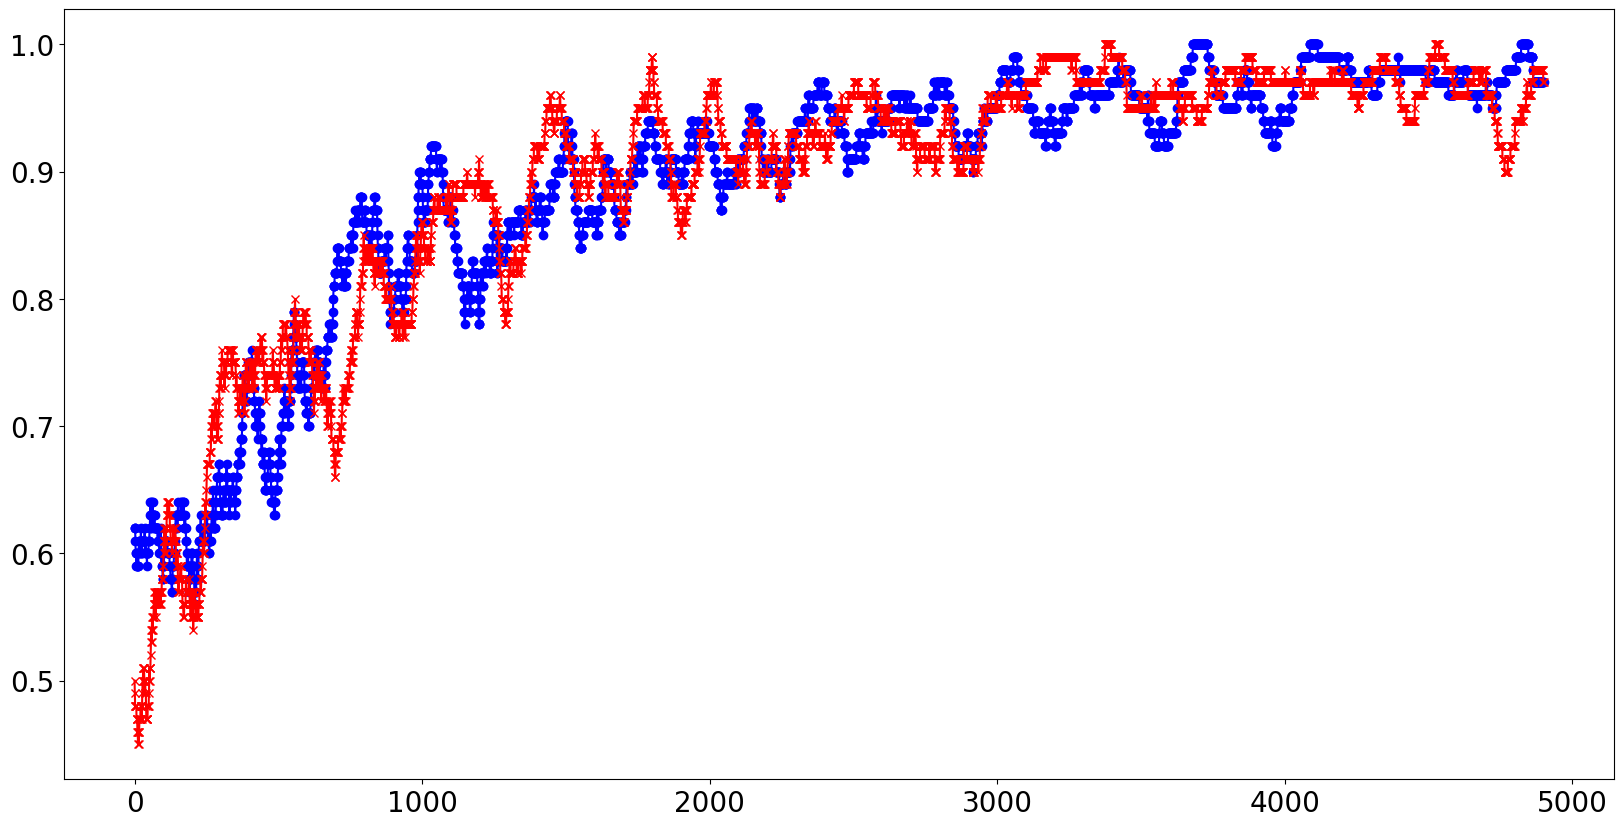

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(actions)[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(actions)[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()

- Almost immediately the value of C is recognized
- Gradually both end up at (C,C)
- No discounting